Crude oil price code in Quandl: OPEC/ORB
Testing Facebook Prophet


In [1]:
import pandas as pd
import quandl as ql
import matplotlib
import matplotlib.pyplot as plt
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt  
import statsmodels.api as sm  
import seaborn as sb  
sb.set_style('darkgrid')
%matplotlib inline
matplotlib.style.use('ggplot')

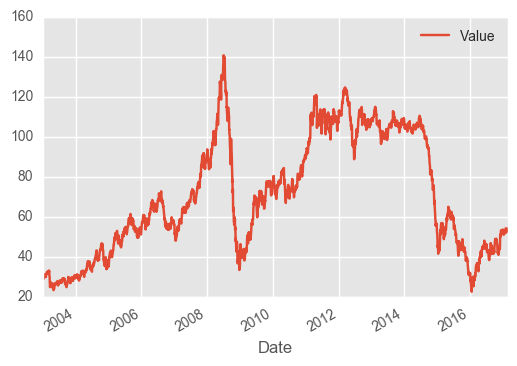

In [2]:
data = ql.get('OPEC/ORB')
data.to_csv('Crude Oil Price.csv')
data.plot() 


In [5]:
df = pd.DataFrame(columns=['ds','y'])
df['ds'] = data.index
df['y'] = data.values
df.head()

,ds,y
0,2003-01-02,30.05
1,2003-01-03,30.83
2,2003-01-06,30.71
3,2003-01-07,29.72
4,2003-01-08,28.86


In [6]:
m = Prophet()
m.fit(df)

In [7]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4014,2018-02-23
4015,2018-02-24
4016,2018-02-25
4017,2018-02-26
4018,2018-02-27


# Look at the Facebook Prophet forecast results for one year

In [8]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4014,2018-02-23,2.108844,-16.153612,19.296524
4015,2018-02-24,5.313343,-12.470420,23.628135
4016,2018-02-25,5.271410,-13.233445,23.745756
4017,2018-02-26,1.837738,-15.291836,19.435186
4018,2018-02-27,1.704202,-16.605203,19.169680


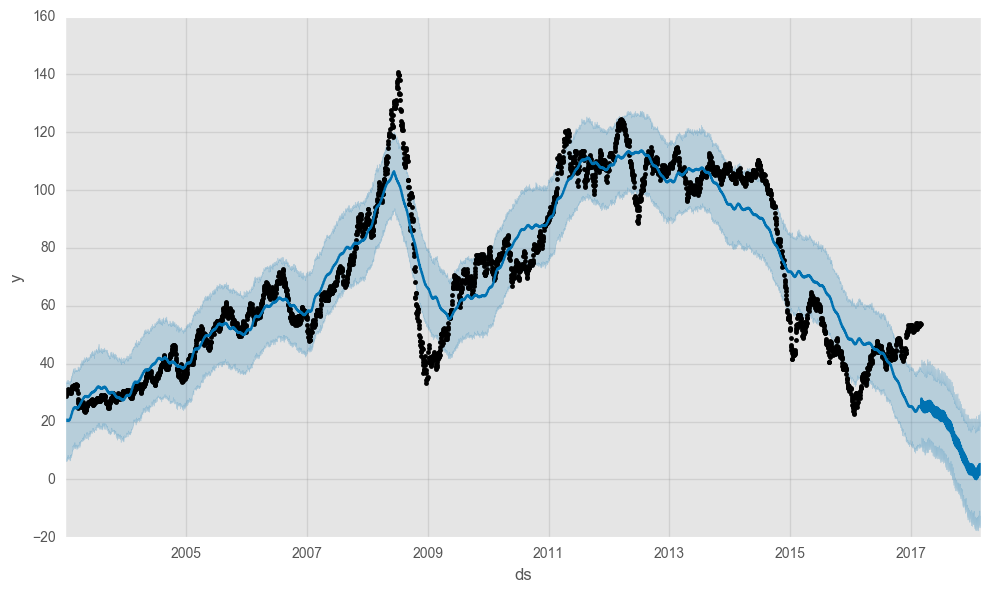

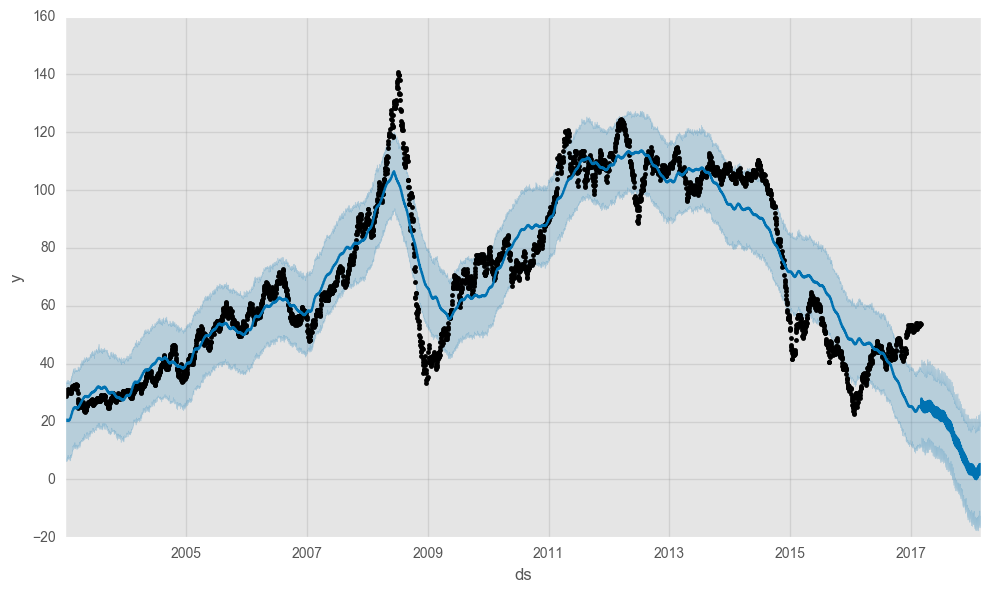

In [9]:
m.plot(forecast)

# Look at the decomposition of the time series

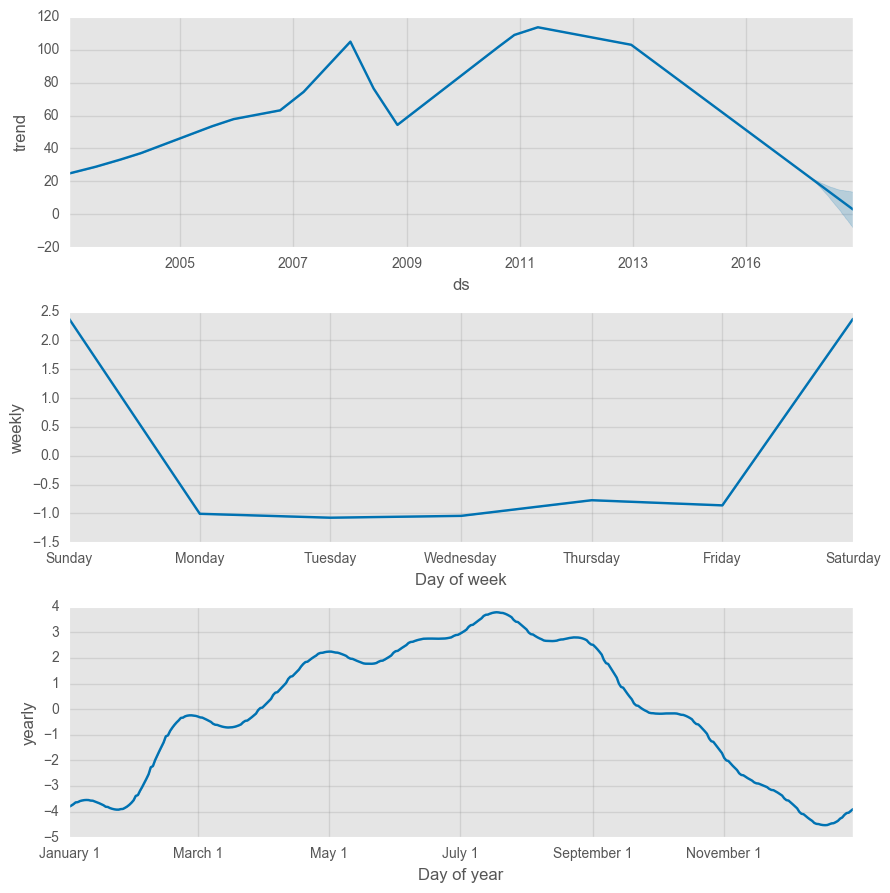

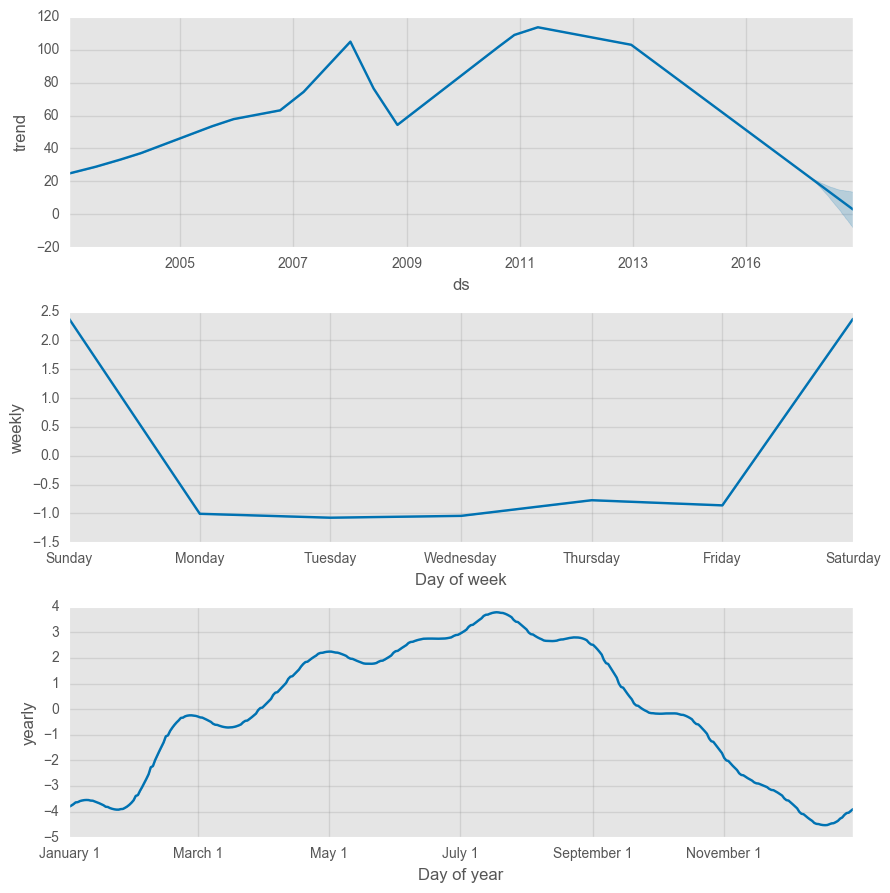

In [10]:
m.plot_components(forecast)

# As seen from the output, doesn't make much sense that the oil price will go to negative. So some domain knowledge and exploratory analysis of the time series is needed for the Facebook Prophet algorithm to generate useful results. In a word, it is data dependdent. 

# It is clear that the data is non-stationary. The first thing is to try the first difference of the time series.


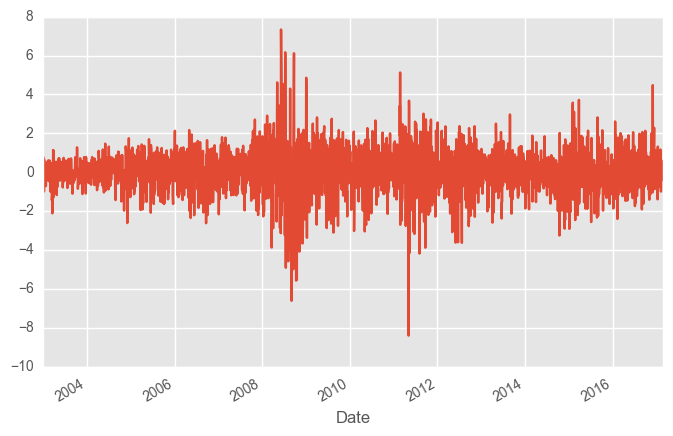

In [11]:

data['First Difference'] = data['Value'] - data['Value'].shift()
data['First Difference'].plot(figsize = (8,5))

The data is no longer appears to be trending up over time and is instead centered around 0.

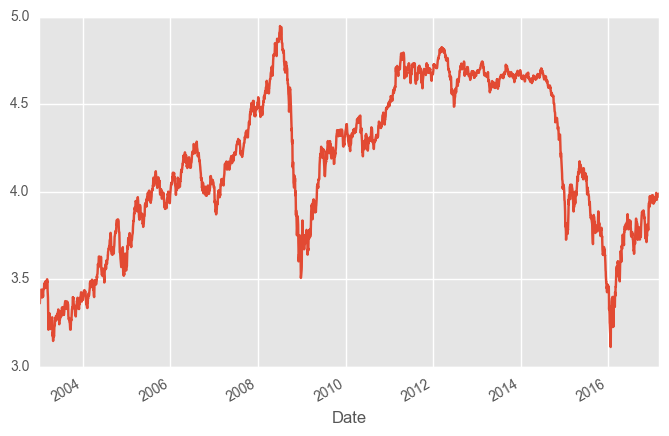

In [12]:
data['Log'] = data['Value'].apply(lambda x: np.log(x))
data['Log'].plot(figsize=(8,5))

Let's compare the variance of the original data and the log(data), in this case, take a rolling variance statistic

/Users/liangkuang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=True).var()
  if __name__ == '__main__':
/Users/liangkuang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=True).var()
  from ipykernel import kernelapp as app


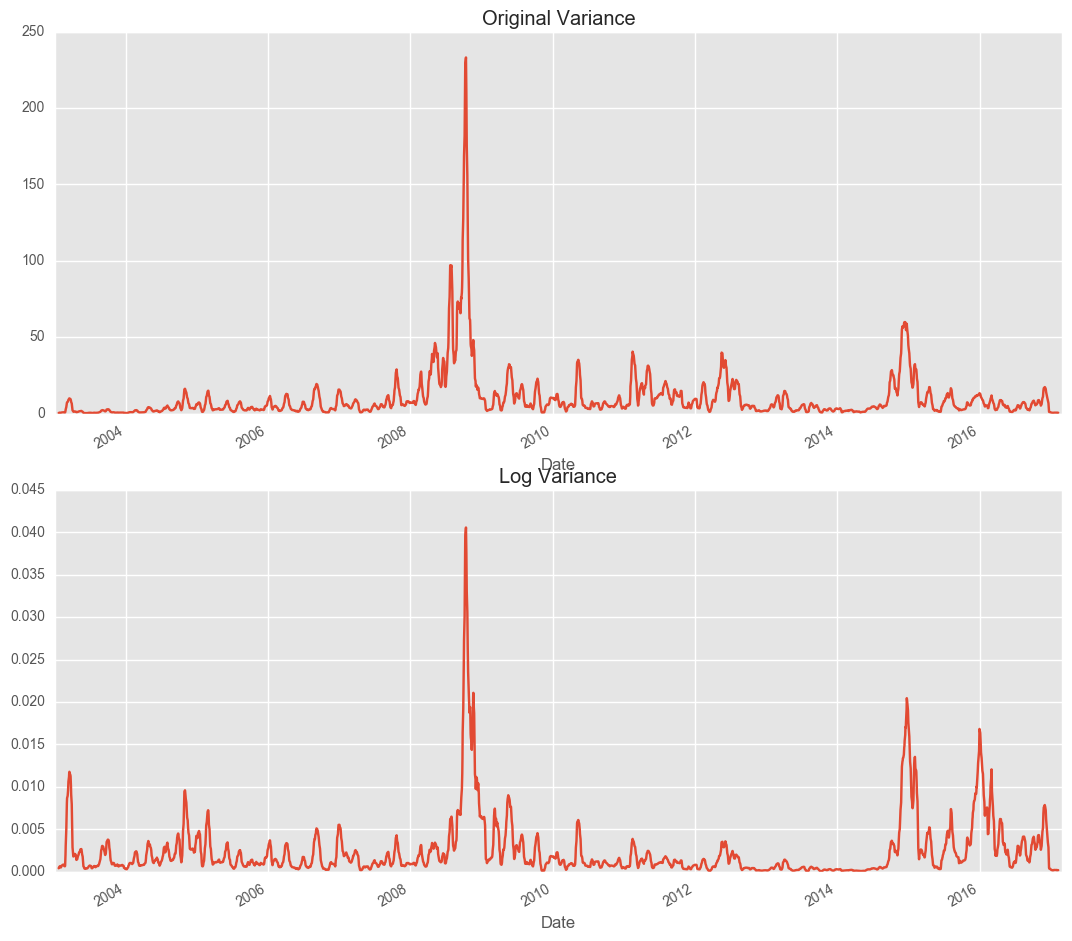

In [13]:
data['Original Variance'] = pd.rolling_var(data['Value'],30,min_periods=None,freq=None,center=True)
data['Log Variance'] = pd.rolling_var(data['Log'],30,min_periods=None,freq=None,center=True)

fig,ax = plt.subplots(2,1,figsize=(13,12))
data['Original Variance'].plot(ax=ax[0],title='Original Variance')
data['Log Variance'].plot(ax=ax[1],title='Log Variance')

## As seen from the variance analysis, the log(data) vs. data doesn't change. The above first difference price seems to be somewhat stationary. Lets create some lag variable y(t-1),y(t-2) etc. and examine their relationship to y(t). For example, the 1 and 2-day lags along with weekly and monthly lags to look for seasonal effects. 

In [14]:
data['Lag 1'] = data['First Difference'].shift()
data['Lag 2'] = data['First Difference'].shift(2)
data['Lag 5'] = data['First Difference'].shift(5)
data['Lag 30'] = data["First Difference"].shift(30)



## use seaborn to visulize the relationship. 

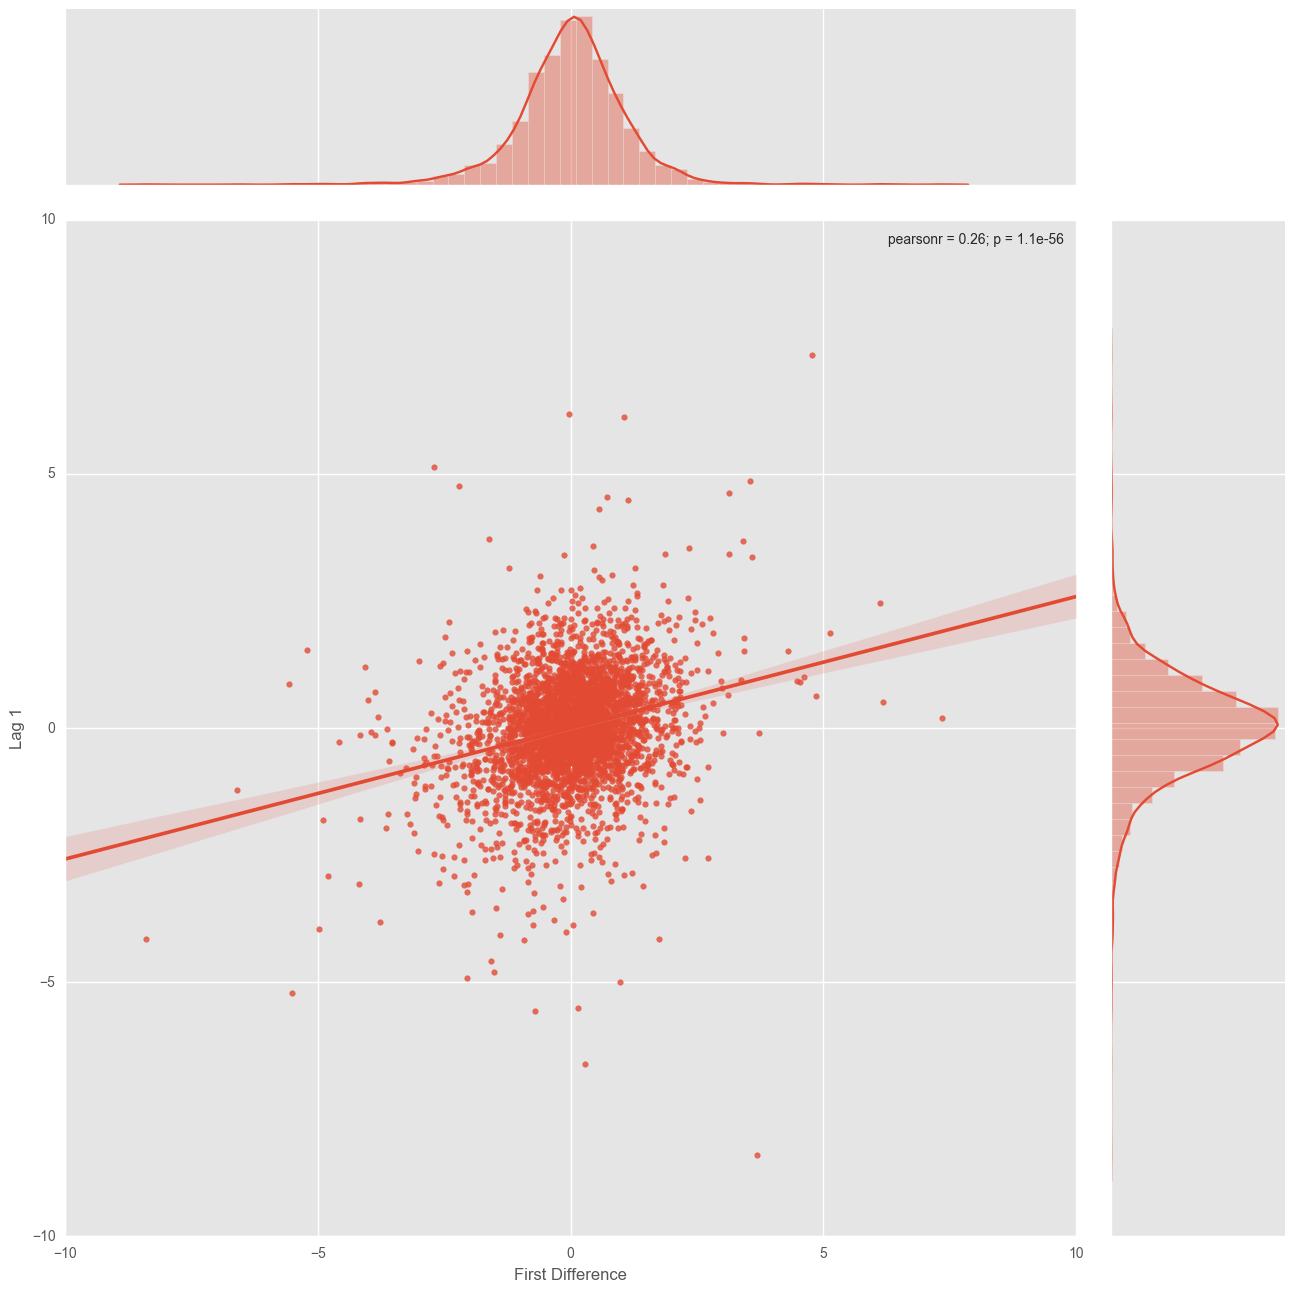

In [15]:
sb.jointplot('First Difference','Lag 1', data, kind='reg', size=13)

## The marginal histogram shows that the 1-day lag is almost the same as 'First Difference'. This tells us the the first day won't tell us much about what will do the next day.
# Let's do the relationship systematically instead. 

In [16]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
lag_correlations = acf(data['First Difference'].iloc[1:])
lag_partial_correlations = pacf(data['First Difference'].iloc[1:])


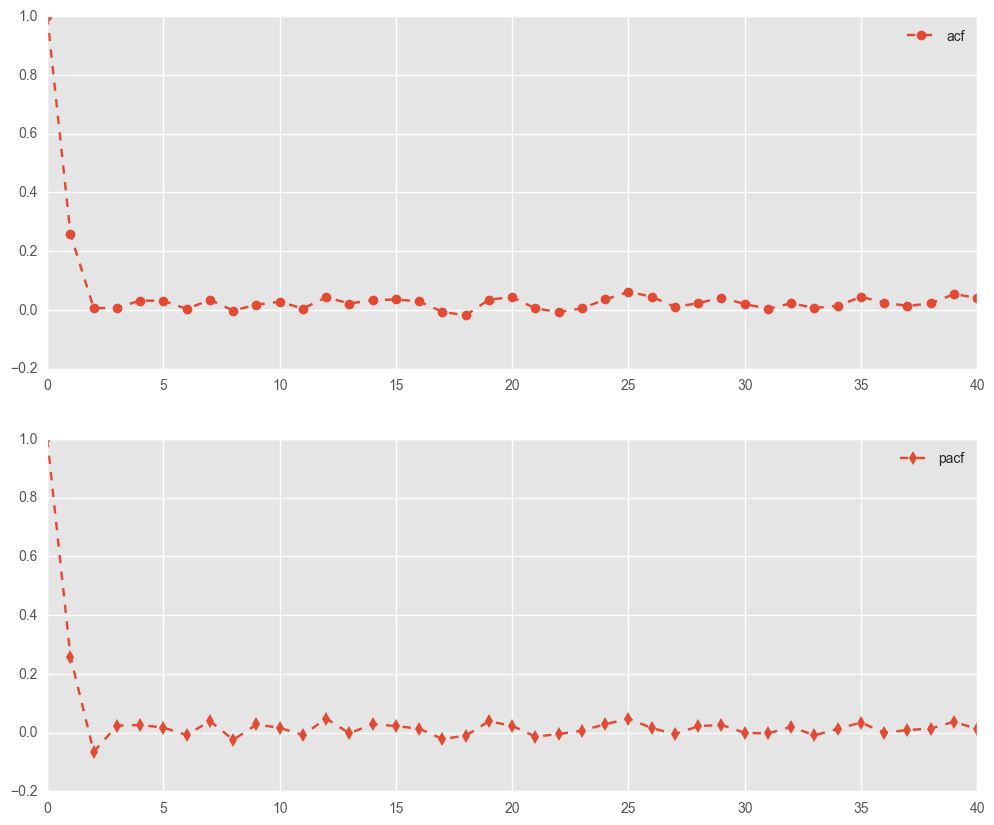

In [18]:
fig,ax = plt.subplots(2,1,figsize=(12,10))
ax[0].plot(lag_correlations,marker='o',linestyle='--',label='acf')
ax[1].plot(lag_partial_correlations,marker='d',linestyle='--',label='pacf')
ax[0].legend()
ax[1].legend()


The auto-correlation and partial-autocorrelation results are very close to each other. What this shows is that there is no significant (> 0.2) correlation between the value at time t and at any time prior to t up to 40 steps behind. In order words, the series is a random walk.

## Let's apply fbpophet to the data

In [19]:
data['ds'] = data.index
df_new = data[['ds','First Difference']]
df_new.columns = ['ds','y']
df_new.head()

,ds,y
Date,,
2003-01-02,2003-01-02,NaN
2003-01-03,2003-01-03,0.78
2003-01-06,2003-01-06,-0.12
2003-01-07,2003-01-07,-0.99
2003-01-08,2003-01-08,-0.86


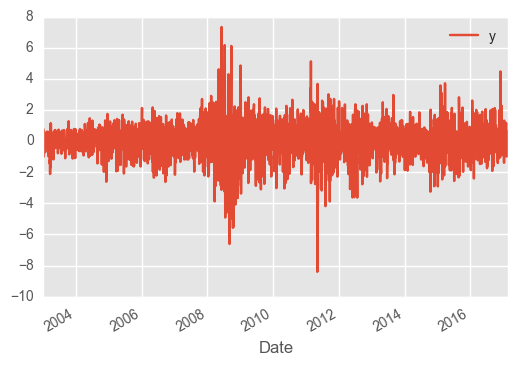

In [20]:
df_new.plot()

In [21]:

m = Prophet()
m.fit(df_new)
future2 = m.make_future_dataframe(periods=365)
forecast2 = m.predict(future2)
forecast2[['ds','yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
4013,2018-02-23,0.174913,-1.116290,1.573285
4014,2018-02-24,0.578417,-0.855192,1.997968
4015,2018-02-25,0.566601,-0.742314,1.865515
4016,2018-02-26,0.058600,-1.258716,1.528663
4017,2018-02-27,0.026536,-1.393570,1.391309


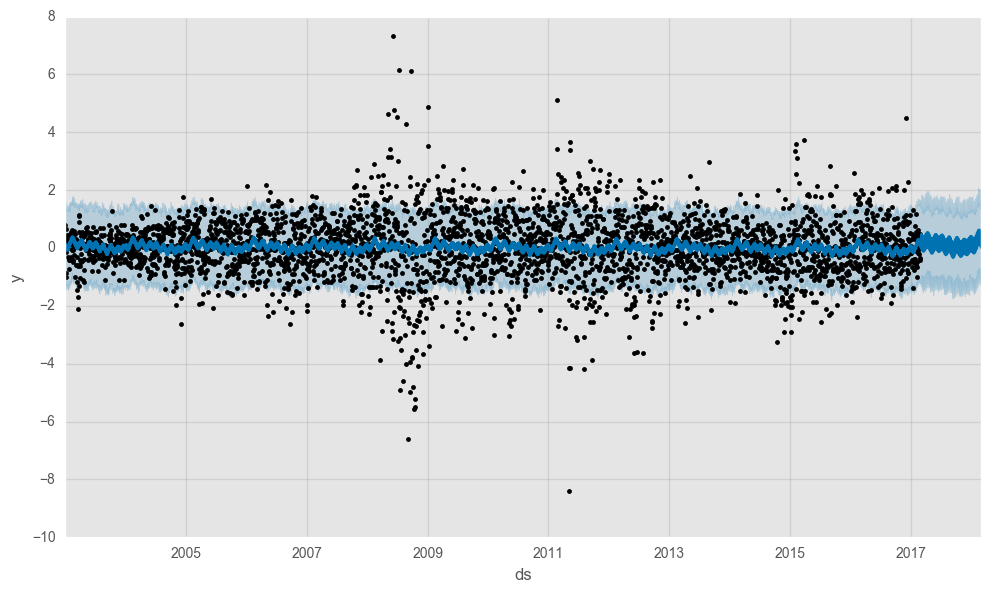

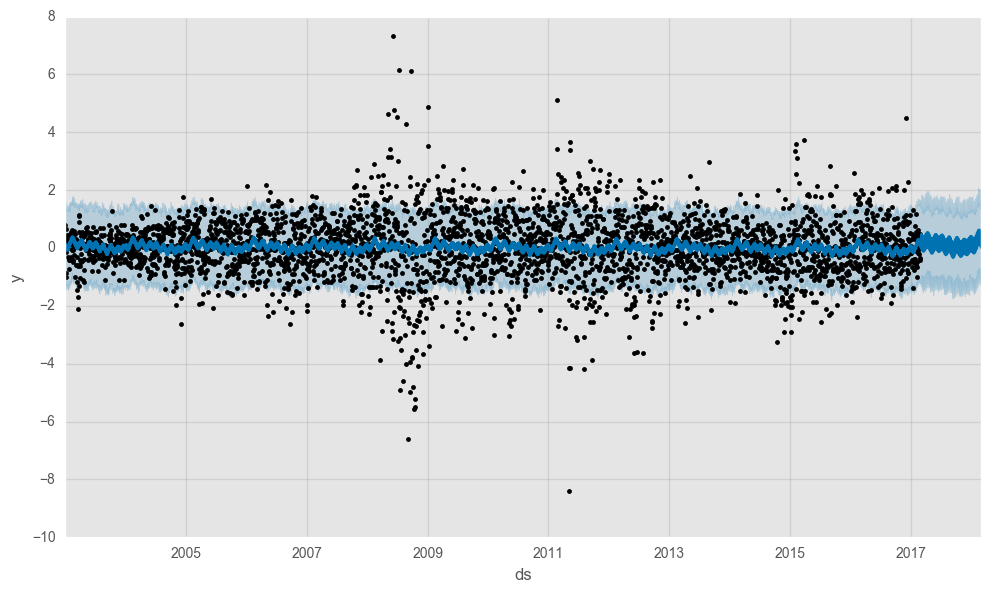

In [22]:
# plot forecast with confedence interval
m.plot(forecast2)


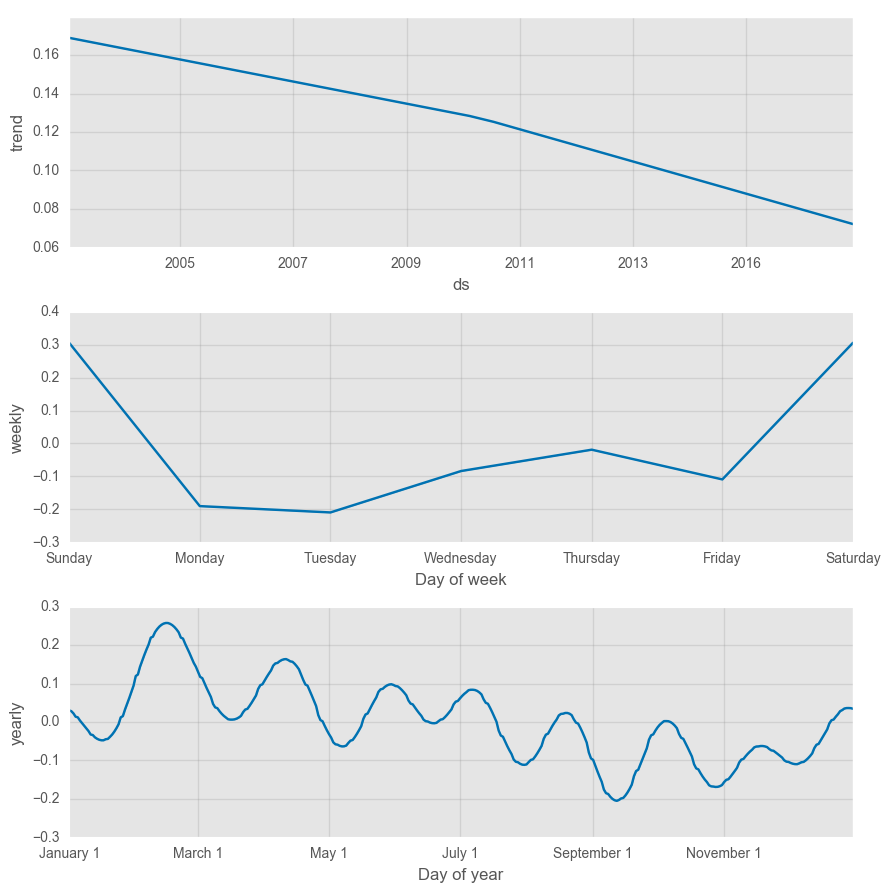

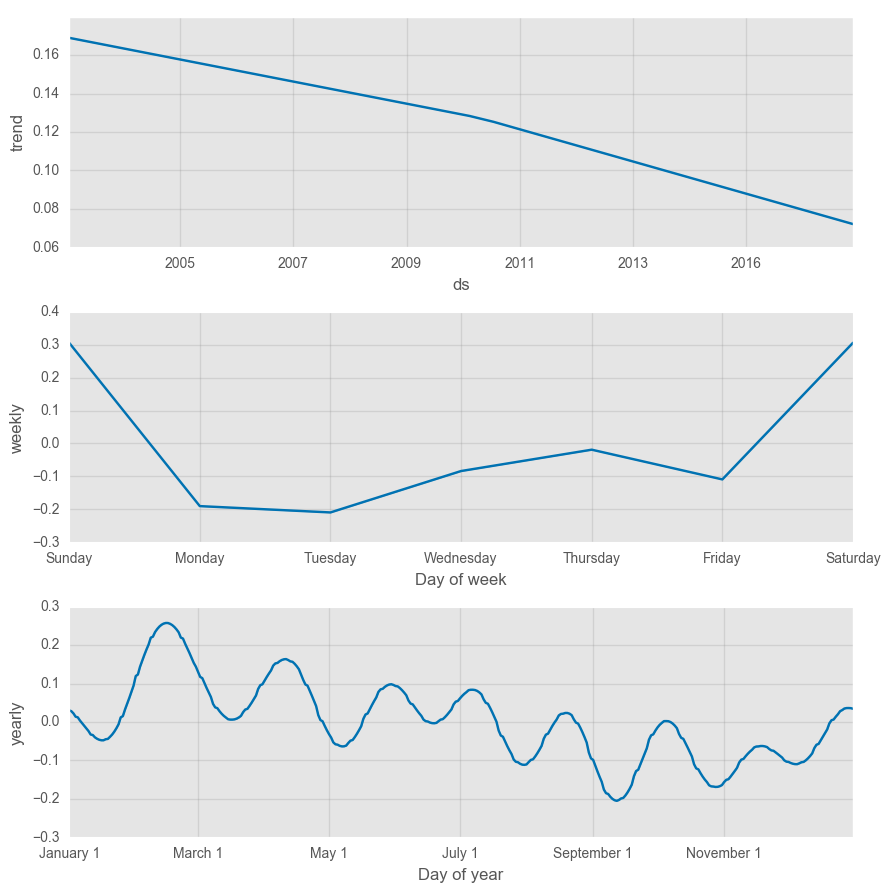

In [23]:
# plot decomposition output from facebook pophet
m.plot_components(forecast2)

## Compare it with Python generic decomposition methods

In [24]:
# Remove missing value
df2 = data[~data['First Difference'].isnull()]

df_sum =pd.DataFrame(df2.isnull().sum()).T
#df2.head()
df2.dtypes

Value                       float64
logPrice                    float64
First Difference            float64
Log                         float64
Original Variance           float64
Log Variance                float64
Lag 1                       float64
Lag 2                       float64
Lag 5                       float64
Lag 30                      float64
ds                   datetime64[ns]
dtype: object

/Users/liangkuang/anaconda/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


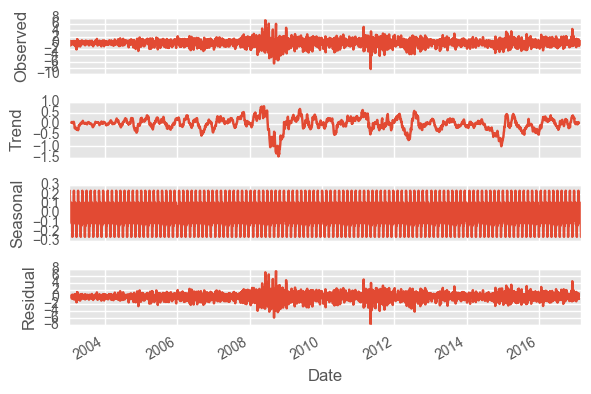

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df2['First Difference'], model='additive',freq=30)

fig = plt.figure(figsize = (16,12))
fig = decomposition.plot()